In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
oil_df=pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/oil.csv")
sample_submission_df=pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv")
holiday_events_df=pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv")
stores_df=pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/stores.csv")
train_df=pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/train.csv")
test_df=pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/test.csv")
transactions_df=pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/transactions.csv")

In [4]:
"""
Daily oil price. Includes values during both the train and test data timeframes.
(Ecuador is an oil-dependent country and it's economical health is highly vulnerable
to shocks in oil prices.)

Take into account that the stock market does not work on weekends. Therefore we will
have jumps in days that do not correspond to datapoints directly, i.e., the price
list with 1000 prices does not correspond to 1000 prices in row days, it is
the price of the first 1000 workdays (discarding holidays, festivities and weekends)
"""
print("Size of the pandas is: ", oil_df.shape)
print(" ")
print("The number of null elements (NaN) is: \n", oil_df.isnull().sum())
print(" ")
#It can be observed the only missing data is in oil_df
print("Information is: \n", oil_df.describe())
print(" ")


#Let´s add two columns for our interest:
oil_df["Month"]=oil_df["date"].apply(lambda x: int(x.split("-")[1]))
oil_df["Year"]=oil_df["date"].apply(lambda x: int(x.split("-")[0].strip()))
oil_df.head()

Size of the pandas is:  (1218, 2)
 
The number of null elements (NaN) is: 
 date           0
dcoilwtico    43
dtype: int64
 
Information is: 
         dcoilwtico
count  1175.000000
mean     67.714366
std      25.630476
min      26.190000
25%      46.405000
50%      53.190000
75%      95.660000
max     110.620000
 


date  dcoilwtico  Month  Year
0  2013-01-01         NaN      1  2013
1  2013-01-02       93.14      1  2013
2  2013-01-03       92.97      1  2013
3  2013-01-04       93.12      1  2013
4  2013-01-07       93.20      1  2013

In [5]:
oil_df.Year.unique()
oil_df[oil_df.Year==2017]

date  dcoilwtico  Month  Year
1044  2017-01-02         NaN      1  2017
1045  2017-01-03       52.36      1  2017
1046  2017-01-04       53.26      1  2017
1047  2017-01-05       53.77      1  2017
1048  2017-01-06       53.98      1  2017
...          ...         ...    ...   ...
1213  2017-08-25       47.65      8  2017
1214  2017-08-28       46.40      8  2017
1215  2017-08-29       46.46      8  2017
1216  2017-08-30       45.96      8  2017
1217  2017-08-31       47.26      8  2017

[174 rows x 4 columns]

In [6]:
print(oil_df.shape[0], oil_df["dcoilwtico"].shape[0])
oil_df.loc[oil_df['Year'] == 2013].index[0]


1218 1218


0

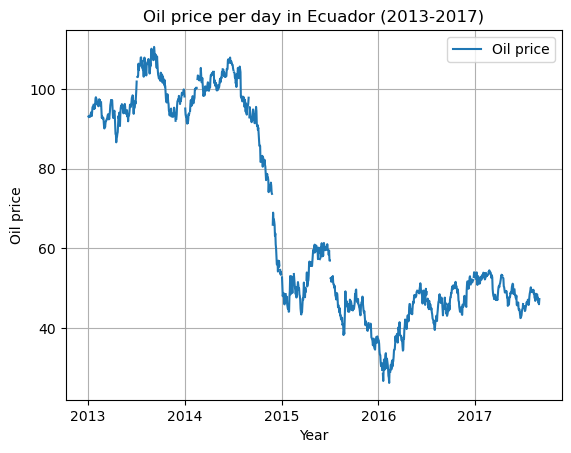

In [7]:
"""
Observe empty areas, that is the NaN part, we will make a tendency to make those missing data be filled
We will fill this data too with an RNN, training with the first not NaN and then filling the NaN part.
We will divide it in sections
"""

# xtick_positions=[0, 1*365, 2*365, 3*365, 4*365] #We can´t do this because of what we explained about weekdays and holidays before
xtick_positions=[oil_df.loc[oil_df['Year'] == 2013].index[0], oil_df.loc[oil_df['Year'] == 2014].index[0],
                 oil_df.loc[oil_df['Year'] == 2015].index[0], oil_df.loc[oil_df['Year'] == 2016].index[0],
                 oil_df.loc[oil_df['Year'] == 2017].index[0]]
xtick_labels=["2013", "2014", "2015", "2016", "2017"]

plt.plot(oil_df["date"], oil_df["dcoilwtico"], label="Oil price")
plt.title("Oil price per day in Ecuador (2013-2017)")
plt.xlabel("Year")
plt.ylabel("Oil price")
plt.xticks(xtick_positions, xtick_labels)
plt.legend()
plt.grid("True")

Text(0.5, 1.0, 'dcoilwtico Frequency per year')

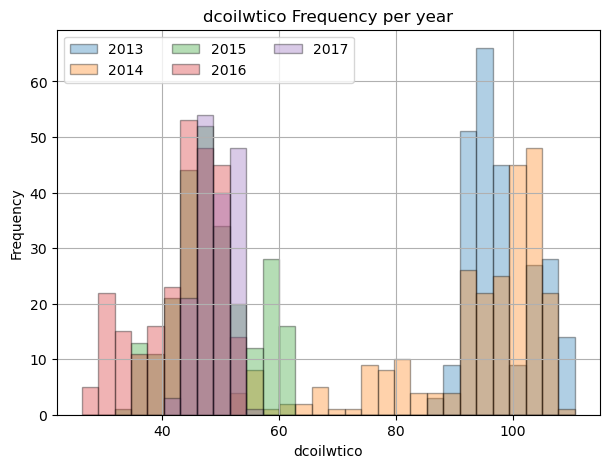

In [8]:
"""
Checking both plots, we can corroborate that the years that had the highest oil price were 2013 and 2014.
After year 2014 the price plumbed. Something happened.
"""


dcoilwtico_hist=pd.concat([oil_df[oil_df.Year==2013]['dcoilwtico'],oil_df[oil_df.Year==2014]['dcoilwtico'], oil_df[oil_df.Year==2015]['dcoilwtico'], oil_df[oil_df.Year==2016]['dcoilwtico'], oil_df[oil_df.Year==2017]['dcoilwtico']],axis=1)
dcoilwtico_hist.columns=["2013", "2014", "2015", "2016", "2017"]
dcoilwtico_hist.plot(kind="hist", bins=30, edgecolor="black", figsize=(7,5), alpha=0.35)
plt.xlabel("dcoilwtico")
plt.grid("True")
plt.legend(ncol=3)
plt.title("dcoilwtico Frequency per year")

In [9]:
print("Size of the pandas is: ", holiday_events_df.shape)
print(" ")
print("The number of null elements (NaN) is: \n", holiday_events_df.isnull().sum())
print(" ")
print("Information is: \n", holiday_events_df.describe())
print(" ")


#Let´s add two columns for our interest:
holiday_events_df["Month"]=holiday_events_df["date"].apply(lambda x: int(x.split("-")[1]))
holiday_events_df["Year"]=holiday_events_df["date"].apply(lambda x: int(x.split("-")[0].strip()))
holiday_events_df.head()

Size of the pandas is:  (350, 6)
 
The number of null elements (NaN) is: 
 date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64
 
Information is: 
               date     type    locale locale_name description transferred
count          350      350       350         350         350         350
unique         312        6         3          24         103           2
top     2014-06-25  Holiday  National     Ecuador    Carnaval       False
freq             4      221       174         174          10         338
 


date     type    locale locale_name                    description  \
0  2012-03-02  Holiday     Local       Manta             Fundacion de Manta   
1  2012-04-01  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
2  2012-04-12  Holiday     Local      Cuenca            Fundacion de Cuenca   
3  2012-04-14  Holiday     Local    Libertad      Cantonizacion de Libertad   
4  2012-04-21  Holiday     Local    Riobamba      Cantonizacion de Riobamba   

   transferred  Month  Year  
0        False      3  2012  
1        False      4  2012  
2        False      4  2012  
3        False      4  2012  
4        False      4  2012

In [10]:
# holiday_events_df["description"].unique() # Here we found that there was a worldwide futbol competition and an earthquake
# Let´s check the dates

longest_events_dates_df=pd.concat([holiday_events_df[holiday_events_df.description.str.contains("Mundial")], holiday_events_df[holiday_events_df.description.str.contains("Terremoto")]])
#These dates can be of interest. Let´s observe when these two events started:
print("Mundial in Brazil started: {} and Earthquake stated: {}".format(holiday_events_df.iloc[holiday_events_df[holiday_events_df.description.str.contains("Mundial")].index[0]]["date"],
                                                                      holiday_events_df.iloc[holiday_events_df[holiday_events_df.description.str.contains("Terremoto")].index[0]]["date"]))

Mundial in Brazil started: 2014-06-12 and Earthquake stated: 2016-04-16


In 2014 they were almost at their top in oil price and in 2016 they were almost at the bottom. The earthquake undermined the oil price at that moment with the last dump.

In [11]:
"""
stores.csv:

Store metadata, including city, state, type, and cluster.
cluster is a grouping of similar stores.
"""
print("Size of the pandas is: ", stores_df.shape)
print(" ")
print("The number of null elements (NaN) is: \n", stores_df.isnull().sum())
print(" ")
print("Information is: \n", stores_df.describe())
print(" ")

stores_df.head()

Size of the pandas is:  (54, 5)
 
The number of null elements (NaN) is: 
 store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64
 
Information is: 
        store_nbr    cluster
count  54.000000  54.000000
mean   27.500000   8.481481
std    15.732133   4.693395
min     1.000000   1.000000
25%    14.250000   4.000000
50%    27.500000   8.500000
75%    40.750000  13.000000
max    54.000000  17.000000
 


store_nbr           city                           state type  cluster
0          1          Quito                       Pichincha    D       13
1          2          Quito                       Pichincha    D       13
2          3          Quito                       Pichincha    D        8
3          4          Quito                       Pichincha    D        9
4          5  Santo Domingo  Santo Domingo de los Tsachilas    D        4

In [12]:
"""
train.csv:

The training data, comprising time series of features store_nbr, family, and onpromotion as well as the target sales.

store_nbr: identifies the store at which the products are sold.
family: identifies the type of product sold.
sales: gives the total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).
onpromotion: gives the total number of items in a product family that were being promoted at a store at a given date.
"""

print("Size of the pandas is: ", train_df.shape)
print(" ")
print("The number of null elements (NaN) is: \n", train_df.isnull().sum())
print(" ")
print("Information is: \n", train_df.describe())
print(" ")

#Let´s add two columns for our interest:
train_df["Month"]=train_df["date"].apply(lambda x: int(x.split("-")[1]))
train_df["Year"]=train_df["date"].apply(lambda x: int(x.split("-")[0]))
train_df["Day"]=train_df["date"].apply(lambda x: int(x.split("-")[2]))
                                                         
train_df.head()

Size of the pandas is:  (3000888, 6)
 
The number of null elements (NaN) is: 
 id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64
 
Information is: 
                  id     store_nbr         sales   onpromotion
count  3.000888e+06  3.000888e+06  3.000888e+06  3.000888e+06
mean   1.500444e+06  2.750000e+01  3.577757e+02  2.602770e+00
std    8.662819e+05  1.558579e+01  1.101998e+03  1.221888e+01
min    0.000000e+00  1.000000e+00  0.000000e+00  0.000000e+00
25%    7.502218e+05  1.400000e+01  0.000000e+00  0.000000e+00
50%    1.500444e+06  2.750000e+01  1.100000e+01  0.000000e+00
75%    2.250665e+06  4.100000e+01  1.958473e+02  0.000000e+00
max    3.000887e+06  5.400000e+01  1.247170e+05  7.410000e+02
 


id        date  store_nbr      family  sales  onpromotion  Month  Year  Day
0   0  2013-01-01          1  AUTOMOTIVE    0.0            0      1  2013    1
1   1  2013-01-01          1   BABY CARE    0.0            0      1  2013    1
2   2  2013-01-01          1      BEAUTY    0.0            0      1  2013    1
3   3  2013-01-01          1   BEVERAGES    0.0            0      1  2013    1
4   4  2013-01-01          1       BOOKS    0.0            0      1  2013    1

In [13]:
train_df[(train_df.store_nbr==1) & (train_df.Year==2013) & (train_df.Month==1)]

id        date  store_nbr                      family    sales  \
0          0  2013-01-01          1                  AUTOMOTIVE    0.000   
1          1  2013-01-01          1                   BABY CARE    0.000   
2          2  2013-01-01          1                      BEAUTY    0.000   
3          3  2013-01-01          1                   BEVERAGES    0.000   
4          4  2013-01-01          1                       BOOKS    0.000   
...      ...         ...        ...                         ...      ...   
53488  53488  2013-01-31          1                     POULTRY  107.302   
53489  53489  2013-01-31          1              PREPARED FOODS   47.000   
53490  53490  2013-01-31          1                     PRODUCE    0.000   
53491  53491  2013-01-31          1  SCHOOL AND OFFICE SUPPLIES    0.000   
53492  53492  2013-01-31          1                     SEAFOOD   25.860   

       onpromotion  Month  Year  Day  
0                0      1  2013    1  
1                0      1  2013    1  
2                0      1  2013    1  
3                0      1  2013    1  
4                0      1  2013    1  
...            ...    ...   ...  ...  
53488            0      1  2013   31  
53489            0      1  2013   31  
53490            0      1  2013   31  
53491            0      1  2013   31  
53492            0      1  2013   31  

[1023 rows x 9 columns]

In [14]:
train_df.loc[train_df['Year'] == 2014].index[0]

648648

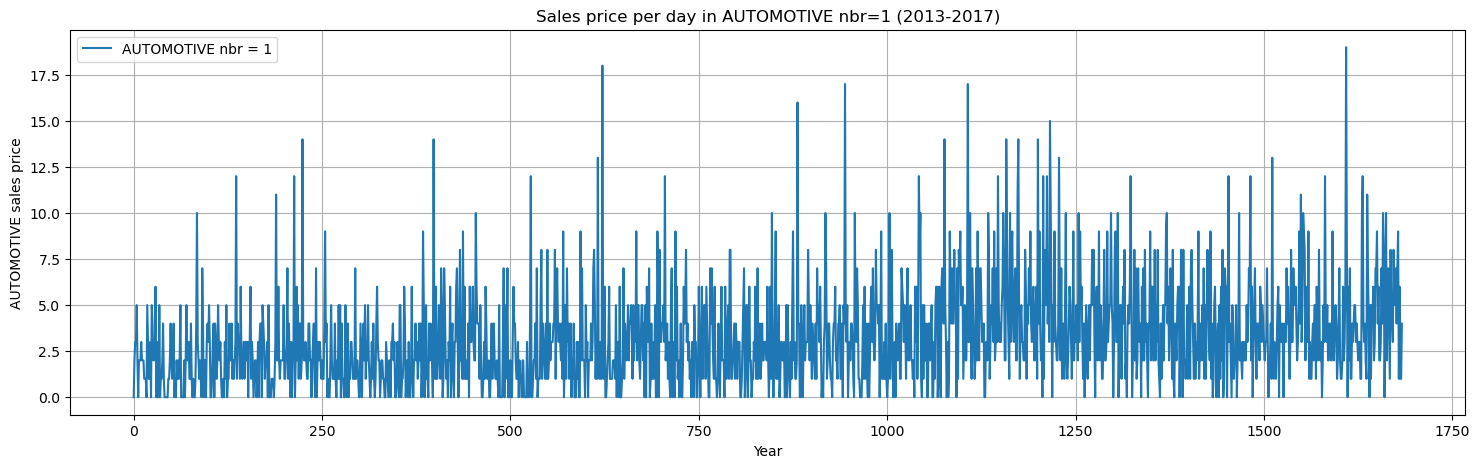

In [15]:
xtick_positions=[train_df.loc[train_df['Year'] == 2013].index[0], train_df.loc[train_df['Year'] == 2014].index[0],
                 train_df.loc[train_df['Year'] == 2015].index[0], train_df.loc[train_df['Year'] == 2016].index[0],
                 train_df.loc[train_df['Year'] == 2017].index[0]]
xtick_labels=["2013", "2014", "2015", "2016", "2017"]

plt.figure(figsize=(18,5))
plt.plot(np.arange(len(train_df[(train_df.store_nbr==1) & (train_df.family=="AUTOMOTIVE")].sales)),
         train_df[(train_df.store_nbr==1) & (train_df.family=="AUTOMOTIVE")].sales, label="AUTOMOTIVE nbr = 1")
plt.title("Sales price per day in AUTOMOTIVE nbr=1 (2013-2017)")
plt.xlabel("Year")
plt.ylabel("AUTOMOTIVE sales price")
#plt.xticks(xtick_positions, xtick_labels)
plt.legend()
plt.grid("True")

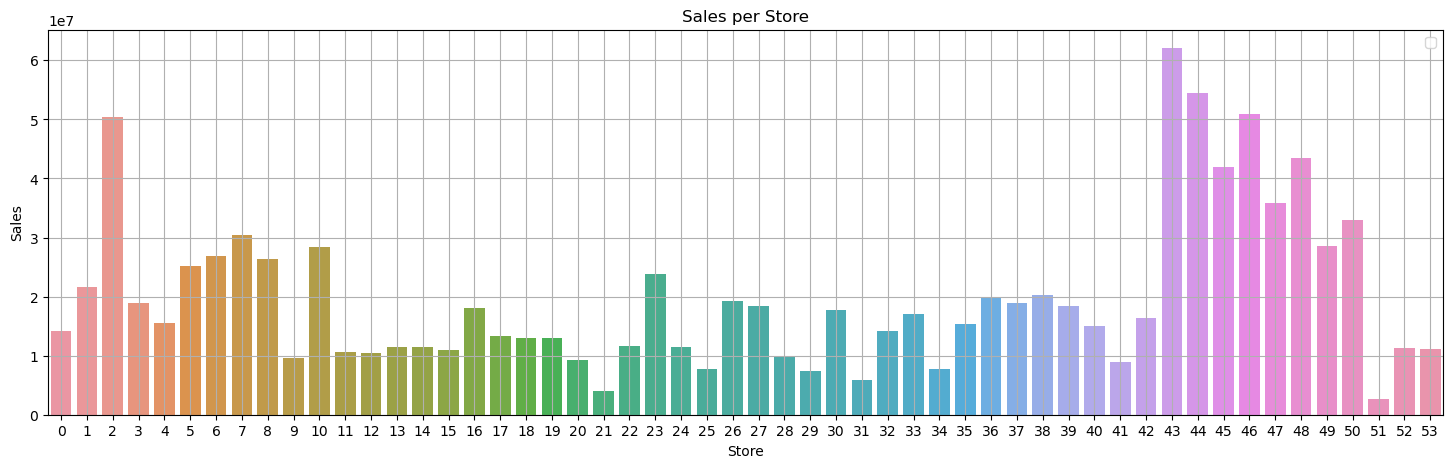

In [20]:
nbr_sales=train_df.groupby(["store_nbr"], as_index=False).agg({"sales":"sum"})

plt.figure(figsize=(18,5))
sns.barplot(x=nbr_sales.index, y="sales", data=nbr_sales)
plt.title("Sales per Store")
plt.xlabel("Store")
plt.ylabel("Sales")
#plt.xticks(xtick_positions, xtick_labels)
plt.legend()
plt.grid("True")

Year         sales
0  2013  1.404190e+08
1  2014  2.094742e+08
2  2015  2.408801e+08
3  2016  2.886545e+08
4  2017  1.942171e+08

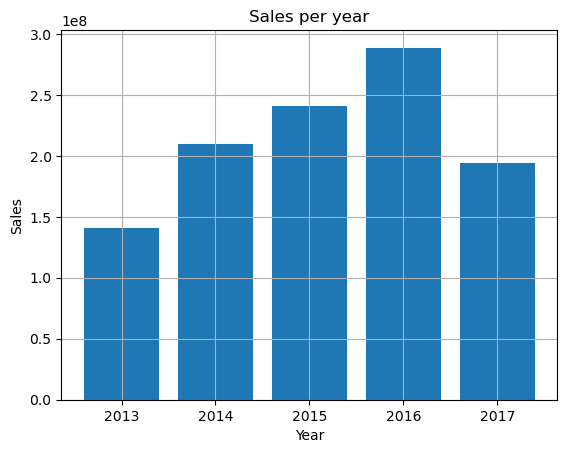

In [26]:
new_year_table=train_df.groupby(["Year"], as_index=False).agg({"sales":"sum"})
#as_index=False to set the Year as a column and have another index instead of Year
plt.bar(new_year_table.Year, new_year_table.sales)
plt.title("Sales per year")
plt.ylabel("Sales")
plt.xlabel("Year")
plt.grid("True")

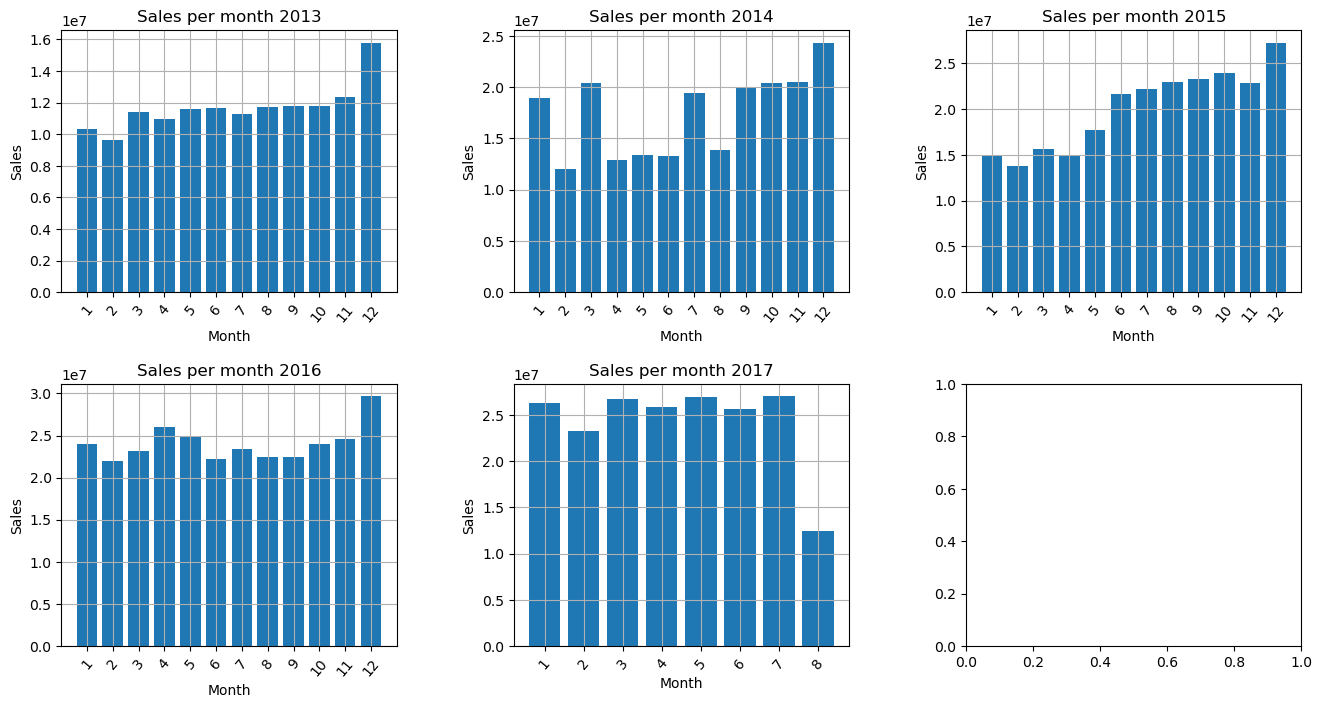

In [65]:
nrows=2
ncols=3
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 8))
plt.subplots_adjust(wspace=0.35, hspace=0.35)
i=0 #i=row
j=0 #j=column
for year in train_df["Year"].unique():
    
    selected_subtable=train_df[train_df["Year"]==year]
    selected_subtable=selected_subtable.groupby(["Month"], as_index=False).agg({"sales":"sum"})
    
    axs[i,j].bar(selected_subtable.Month, selected_subtable.sales)
    axs[i,j].set_xticks(selected_subtable.Month)
    axs[i,j].set_xticklabels(selected_subtable.Month, rotation=50)
    axs[i,j].set_title("Sales per month {}".format(str(year)))
    axs[i,j].set_xlabel("Month")
    axs[i,j].set_ylabel("Sales")
    axs[i,j].grid(True)
    j=j+1
    if j==ncols:
        i=i+1
        j=0

In [28]:
train_df.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'Month',
       'Year', 'Day'],
      dtype='object')

In [77]:
import plotly.graph_objects as go
from plotly.offline import plot

In [79]:
pie=go.Pie(labels=["Not promotion","Promotion"],
          values=train_df.onpromotion.value_counts().values,
          text=["Not promotion", "Promotion"],
          hoverinfo="label+value",
          domain=dict(x=[0,0.48], y=[0.5,1]),
          showlegend=False
          )

item_pie_layout=dict(width=800, height=700,
                    title="% of items on promotion")

fig = go.Figure(data=pie, layout=item_pie_layout)
fig.show()

Let´s analyze the best (apparently) year 2015

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'Month',
       'Year', 'Day'],
      dtype='object')

In [112]:
store_sales_df=train_df.merge(stores_df, how="inner", on="store_nbr")
store_sales_2015_df=store_sales_df[store_sales_df.Year==2015]
store_sales_2015_df.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'Month',
       'Year', 'Day', 'city', 'state', 'type', 'cluster'],
      dtype='object')

In [118]:
sales_2015_df.iloc[0]

onpromotion      235.000
sales          13186.046
Name: 231, dtype: float64

<Figure size 640x480 with 0 Axes>

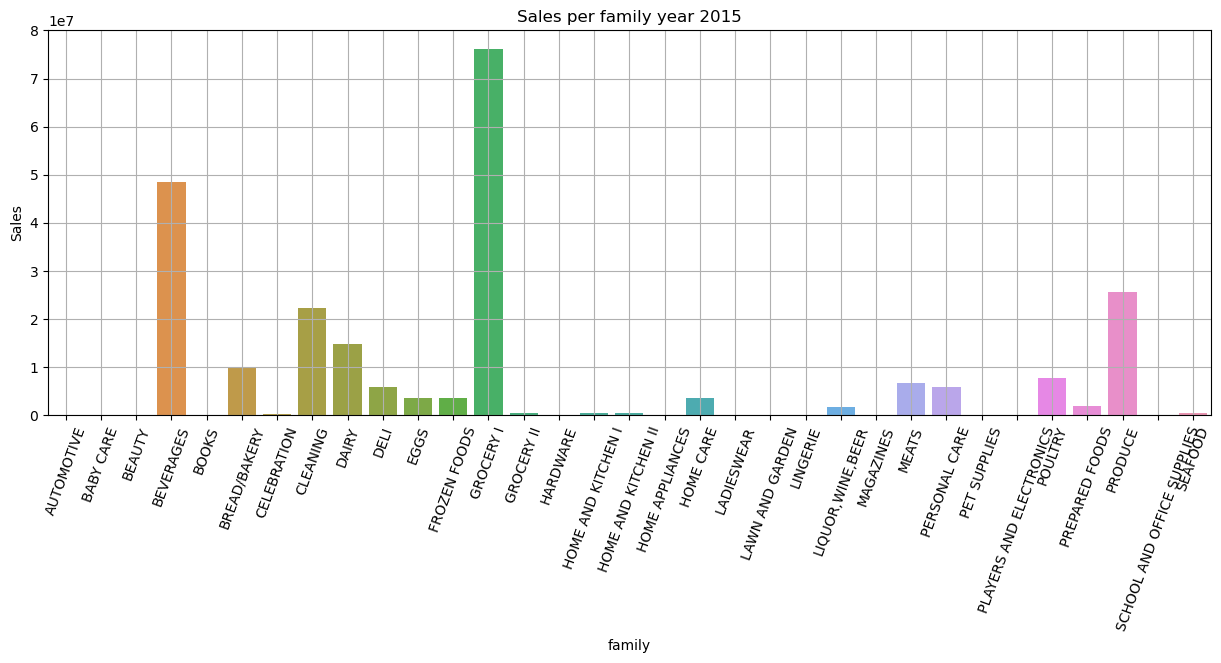

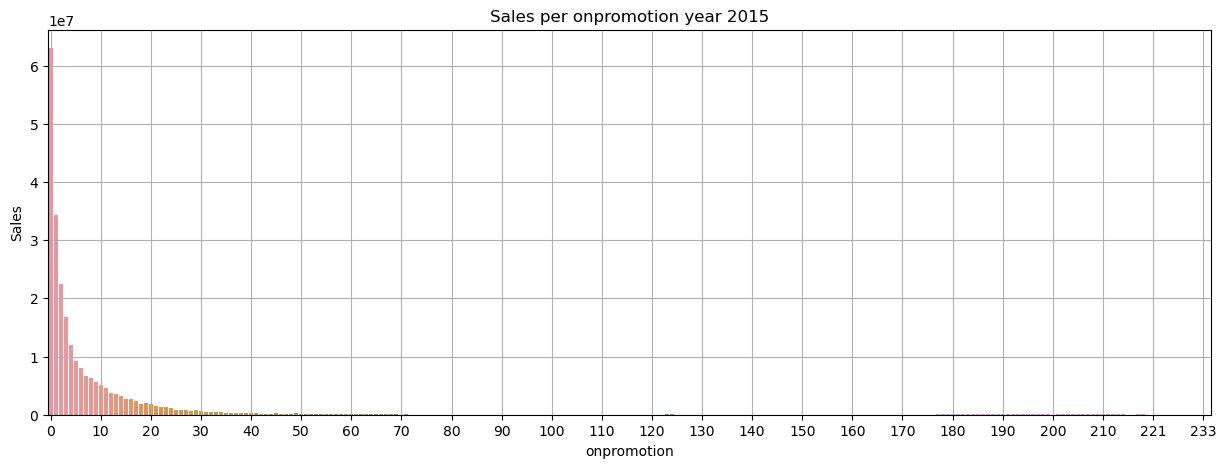

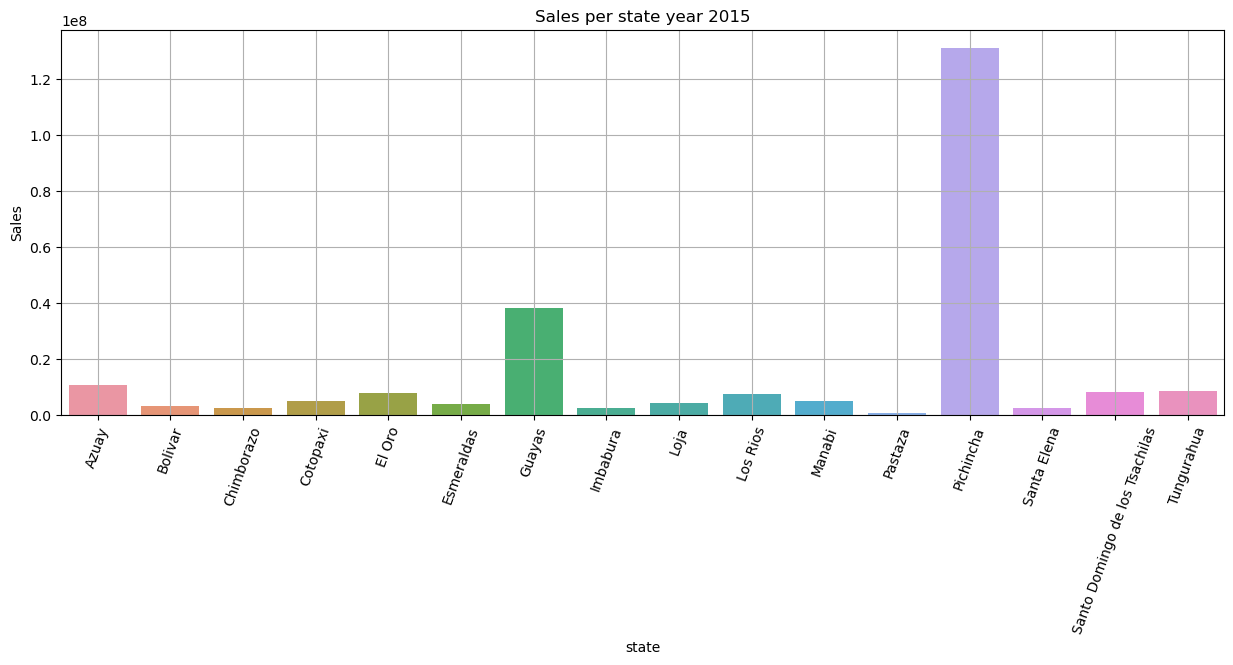

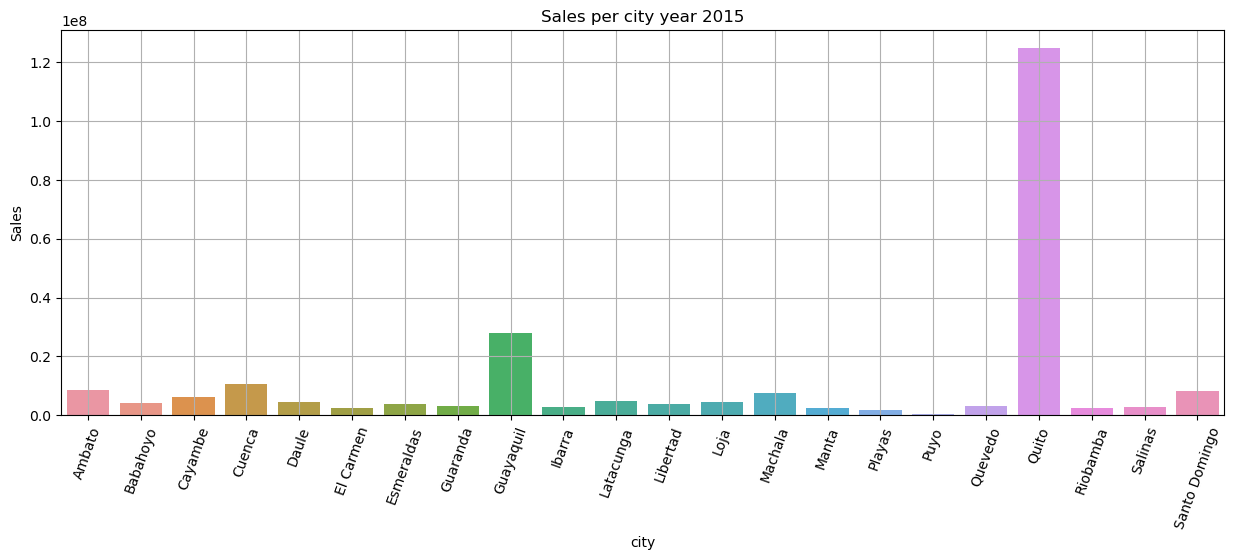

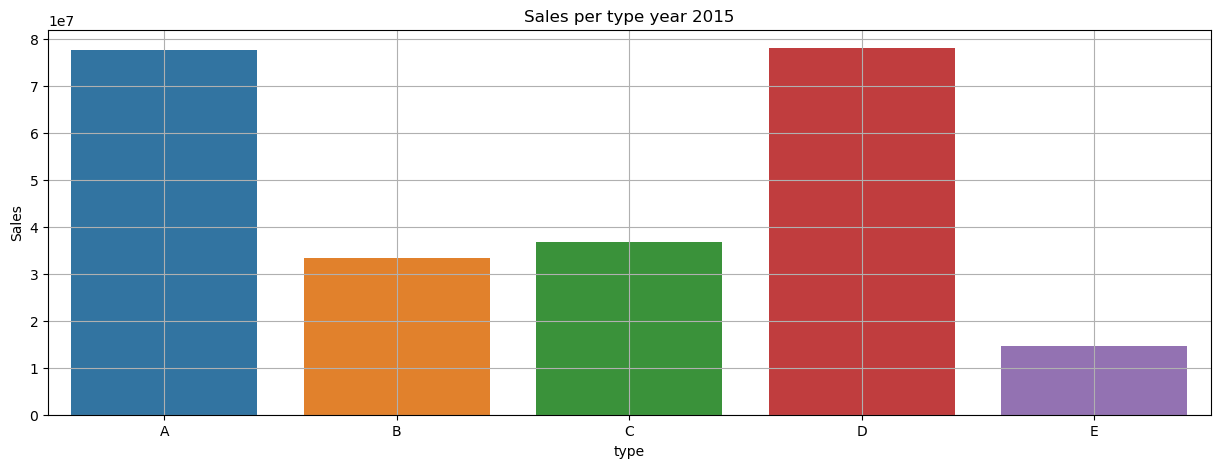

In [121]:
list_name=["family", "onpromotion", "state", "city", "type", "cluster", "store_nbr"]
plt.subplots_adjust(wspace=0.35, hspace=0.35)
for name in list_name:
    plt.figure(figsize=(15,5))
    sales_2015_df=store_sales_2015_df.groupby([name], as_index=False).agg({"sales":"sum"})
    sns.barplot(x=sales_2015_df[name], y="sales", data=sales_2015_df)
    plt.title("Sales per {} year {}".format(name,2015))
    plt.ylabel("Sales")
    plt.xlabel(name)
    if name=="state" or name=="city" or name=="family":
        plt.xticks(rotation=70)
    elif name=="onpromotion":
        plt.xticks(range(0, len(sales_2015_df[name]), 10))
    else:
        plt.xticks(rotation=0)
    plt.grid("True")
    plt.show()

In [101]:
store_sales_2015_df.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'Month',
       'Year', 'Day', 'city', 'state', 'type', 'cluster'],
      dtype='object')

In [142]:
transactions_df["date"]=pd.to_datetime(transactions_df["date"])
transactions_df["Day_of_week"]=transactions_df["date"].dt.day_name()
transactions_df["Month"]=transactions_df["date"].dt.month
transactions_df["Year"]=transactions_df["date"].dt.year.astype(str)
transactions_df

date  store_nbr  transactions  Month  Year  Day Day_of_week
0     2013-01-01         25           770      1  2013    1     Tuesday
1     2013-01-02          1          2111      1  2013    2   Wednesday
2     2013-01-02          2          2358      1  2013    2   Wednesday
3     2013-01-02          3          3487      1  2013    2   Wednesday
4     2013-01-02          4          1922      1  2013    2   Wednesday
...          ...        ...           ...    ...   ...  ...         ...
83483 2017-08-15         50          2804      8  2017   15     Tuesday
83484 2017-08-15         51          1573      8  2017   15     Tuesday
83485 2017-08-15         52          2255      8  2017   15     Tuesday
83486 2017-08-15         53           932      8  2017   15     Tuesday
83487 2017-08-15         54           802      8  2017   15     Tuesday

[83488 rows x 7 columns]

/tmp/ipykernel_32/1979295589.py:5: FutureWarning:

In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.



/tmp/ipykernel_32/1979295589.py:5: FutureWarning:

In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.



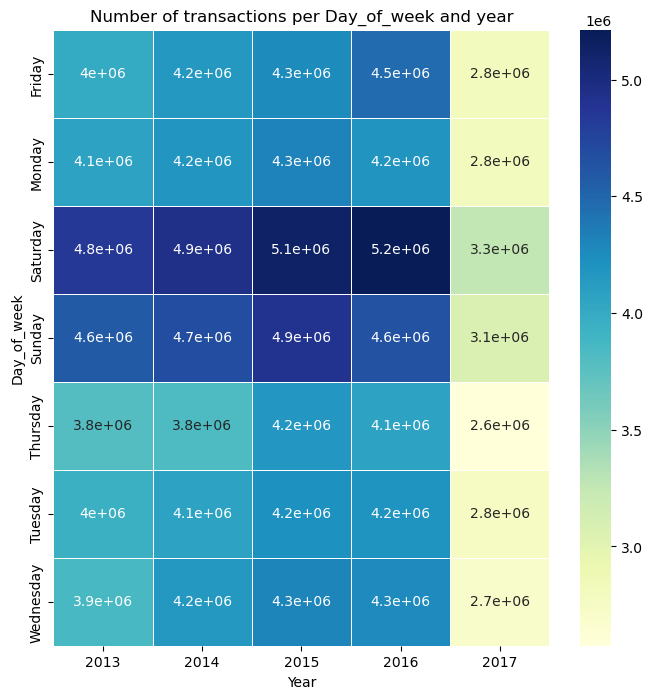

In [154]:
list_names=["Month", "Day_of_week"]
for name in list_names:
    plt.figure(figsize=(8,8))
    new_subtable=transactions_df.groupby([name, "Year"], as_index=False).agg({"transactions":"sum"})
    heat_map=new_subtable.pivot(name, "Year", "transactions")
    sns.heatmap(heat_map, annot=True, linecolor="white", linewidths=0.5, cmap="YlGnBu")
    plt.xlabel("Year")
    plt.ylabel(name)
    plt.title("Number of transactions per {} and year".format(name))
    plt.show()

In [155]:
holiday_events_df

date        type    locale locale_name  \
0    2012-03-02     Holiday     Local       Manta   
1    2012-04-01     Holiday  Regional    Cotopaxi   
2    2012-04-12     Holiday     Local      Cuenca   
3    2012-04-14     Holiday     Local    Libertad   
4    2012-04-21     Holiday     Local    Riobamba   
..          ...         ...       ...         ...   
345  2017-12-22  Additional  National     Ecuador   
346  2017-12-23  Additional  National     Ecuador   
347  2017-12-24  Additional  National     Ecuador   
348  2017-12-25     Holiday  National     Ecuador   
349  2017-12-26  Additional  National     Ecuador   

                       description  transferred  Month  Year  
0               Fundacion de Manta        False      3  2012  
1    Provincializacion de Cotopaxi        False      4  2012  
2              Fundacion de Cuenca        False      4  2012  
3        Cantonizacion de Libertad        False      4  2012  
4        Cantonizacion de Riobamba        False      4  2012  
..                             ...          ...    ...   ...  
345                      Navidad-3        False     12  2017  
346                      Navidad-2        False     12  2017  
347                      Navidad-1        False     12  2017  
348                        Navidad        False     12  2017  
349                      Navidad+1        False     12  2017  

[350 rows x 8 columns]

In [156]:
train_df

id        date  store_nbr                      family     sales  \
0              0  2013-01-01          1                  AUTOMOTIVE     0.000   
1              1  2013-01-01          1                   BABY CARE     0.000   
2              2  2013-01-01          1                      BEAUTY     0.000   
3              3  2013-01-01          1                   BEVERAGES     0.000   
4              4  2013-01-01          1                       BOOKS     0.000   
...          ...         ...        ...                         ...       ...   
3000883  3000883  2017-08-15          9                     POULTRY   438.133   
3000884  3000884  2017-08-15          9              PREPARED FOODS   154.553   
3000885  3000885  2017-08-15          9                     PRODUCE  2419.729   
3000886  3000886  2017-08-15          9  SCHOOL AND OFFICE SUPPLIES   121.000   
3000887  3000887  2017-08-15          9                     SEAFOOD    16.000   

         onpromotion  Month  Year  Day  
0                  0      1  2013    1  
1                  0      1  2013    1  
2                  0      1  2013    1  
3                  0      1  2013    1  
4                  0      1  2013    1  
...              ...    ...   ...  ...  
3000883            0      8  2017   15  
3000884            1      8  2017   15  
3000885          148      8  2017   15  
3000886            8      8  2017   15  
3000887            0      8  2017   15  

[3000888 rows x 9 columns]

In [158]:
holiday_sales_df=train_df.merge(holiday_events_df, how="inner", on="date")
holiday_sales_df

id        date  store_nbr                      family     sales  \
0             0  2013-01-01          1                  AUTOMOTIVE     0.000   
1             1  2013-01-01          1                   BABY CARE     0.000   
2             2  2013-01-01          1                      BEAUTY     0.000   
3             3  2013-01-01          1                   BEVERAGES     0.000   
4             4  2013-01-01          1                       BOOKS     0.000   
...         ...         ...        ...                         ...       ...   
502519  3000883  2017-08-15          9                     POULTRY   438.133   
502520  3000884  2017-08-15          9              PREPARED FOODS   154.553   
502521  3000885  2017-08-15          9                     PRODUCE  2419.729   
502522  3000886  2017-08-15          9  SCHOOL AND OFFICE SUPPLIES   121.000   
502523  3000887  2017-08-15          9                     SEAFOOD    16.000   

        onpromotion  Month_x  Year_x  Day     type    locale locale_name  \
0                 0        1    2013    1  Holiday  National     Ecuador   
1                 0        1    2013    1  Holiday  National     Ecuador   
2                 0        1    2013    1  Holiday  National     Ecuador   
3                 0        1    2013    1  Holiday  National     Ecuador   
4                 0        1    2013    1  Holiday  National     Ecuador   
...             ...      ...     ...  ...      ...       ...         ...   
502519            0        8    2017   15  Holiday     Local    Riobamba   
502520            1        8    2017   15  Holiday     Local    Riobamba   
502521          148        8    2017   15  Holiday     Local    Riobamba   
502522            8        8    2017   15  Holiday     Local    Riobamba   
502523            0        8    2017   15  Holiday     Local    Riobamba   

                  description  transferred  Month_y  Year_y  
0          Primer dia del ano        False        1    2013  
1          Primer dia del ano        False        1    2013  
2          Primer dia del ano        False        1    2013  
3          Primer dia del ano        False        1    2013  
4          Primer dia del ano        False        1    2013  
...                       ...          ...      ...     ...  
502519  Fundacion de Riobamba        False        8    2017  
502520  Fundacion de Riobamba        False        8    2017  
502521  Fundacion de Riobamba        False        8    2017  
502522  Fundacion de Riobamba        False        8    2017  
502523  Fundacion de Riobamba        False        8    2017  

[502524 rows x 16 columns]

In [177]:
holiday_sales_2015_df.transferred.value_counts().unique()

array([90882])

Year 2013:


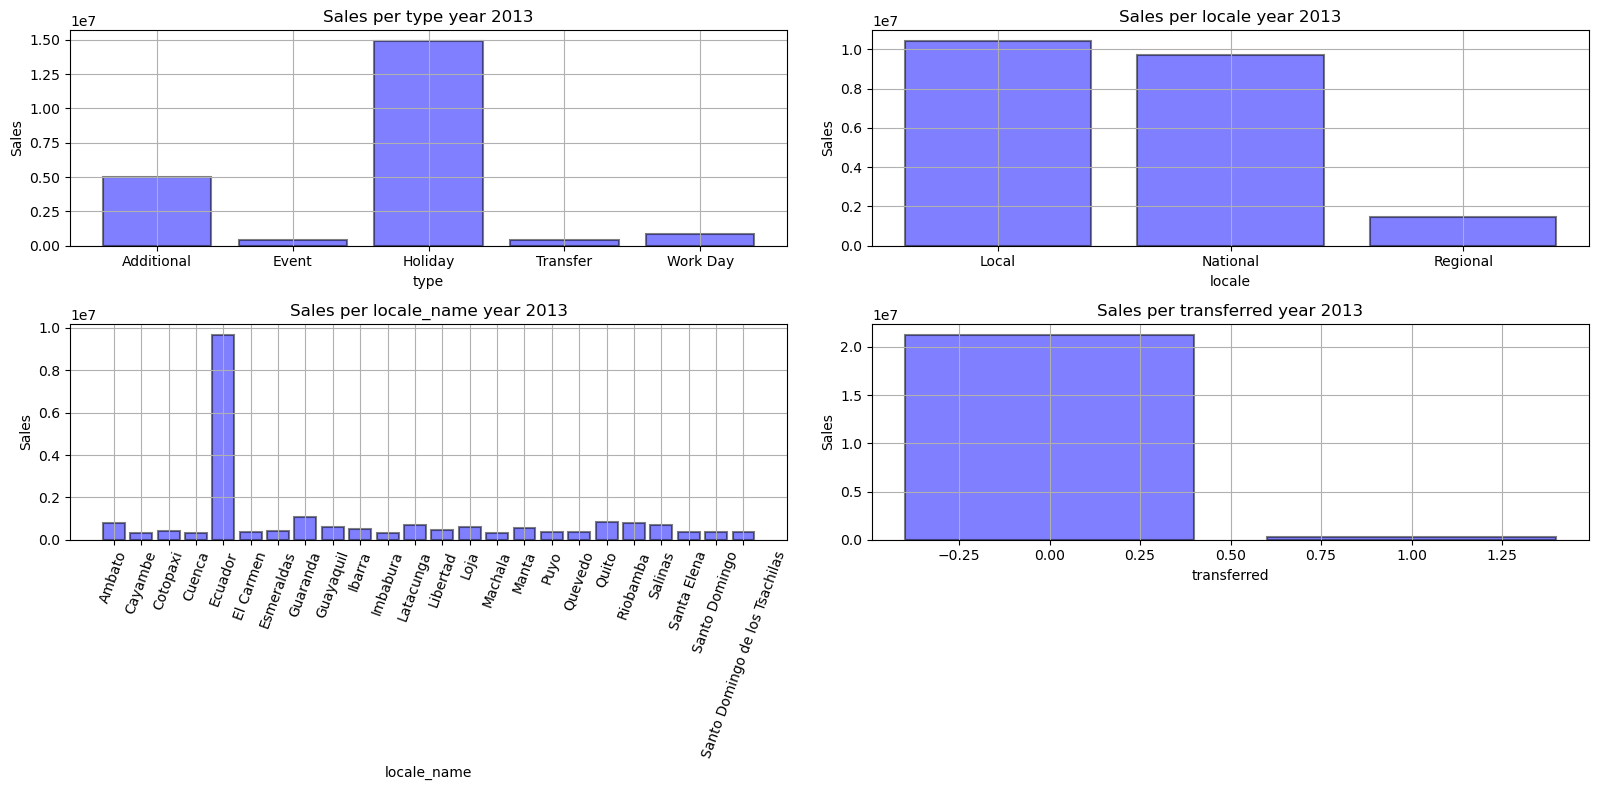







Year 2014:


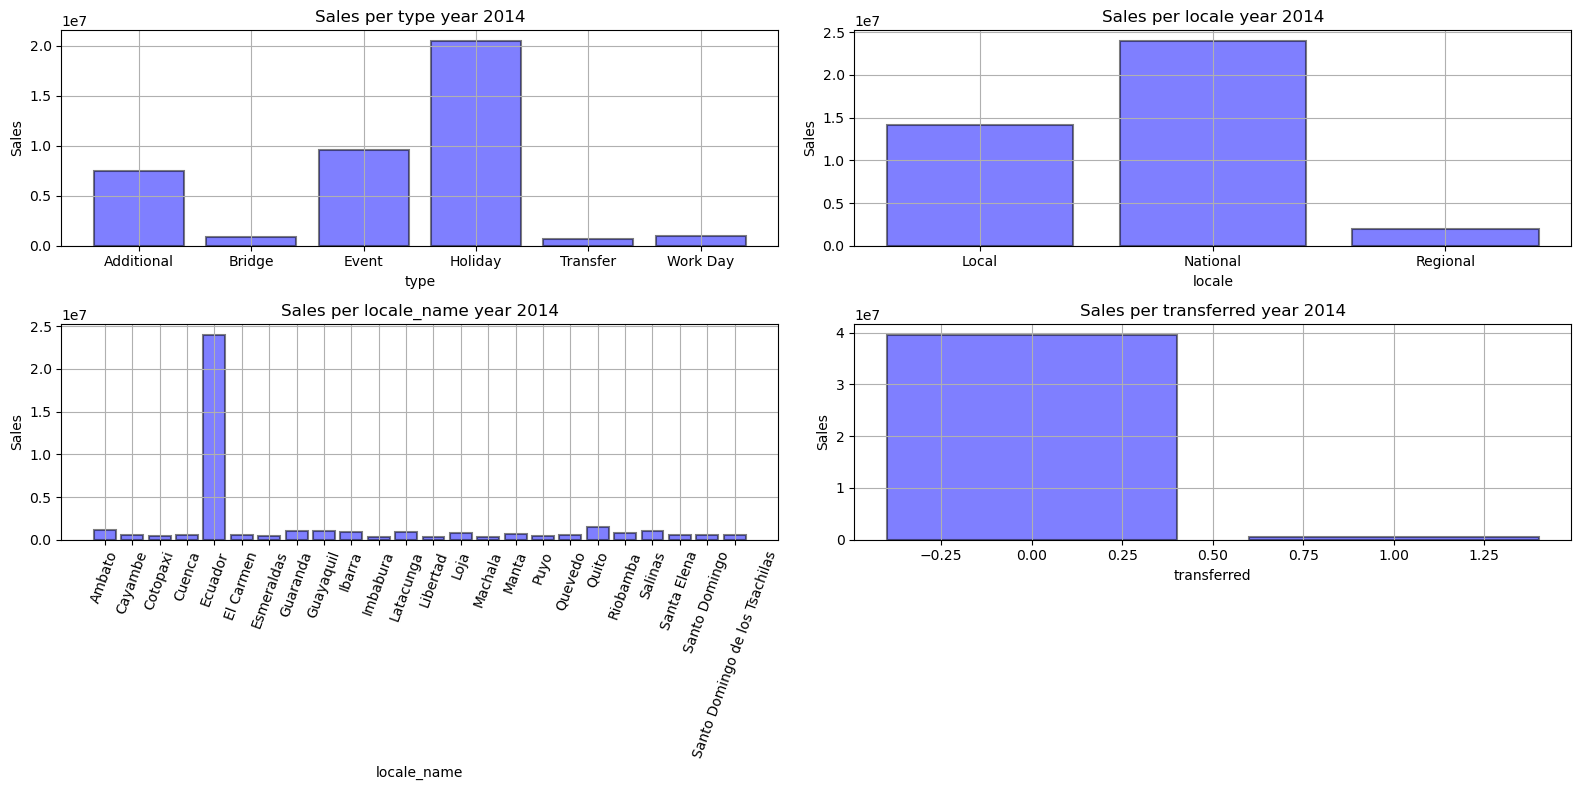







Year 2015:


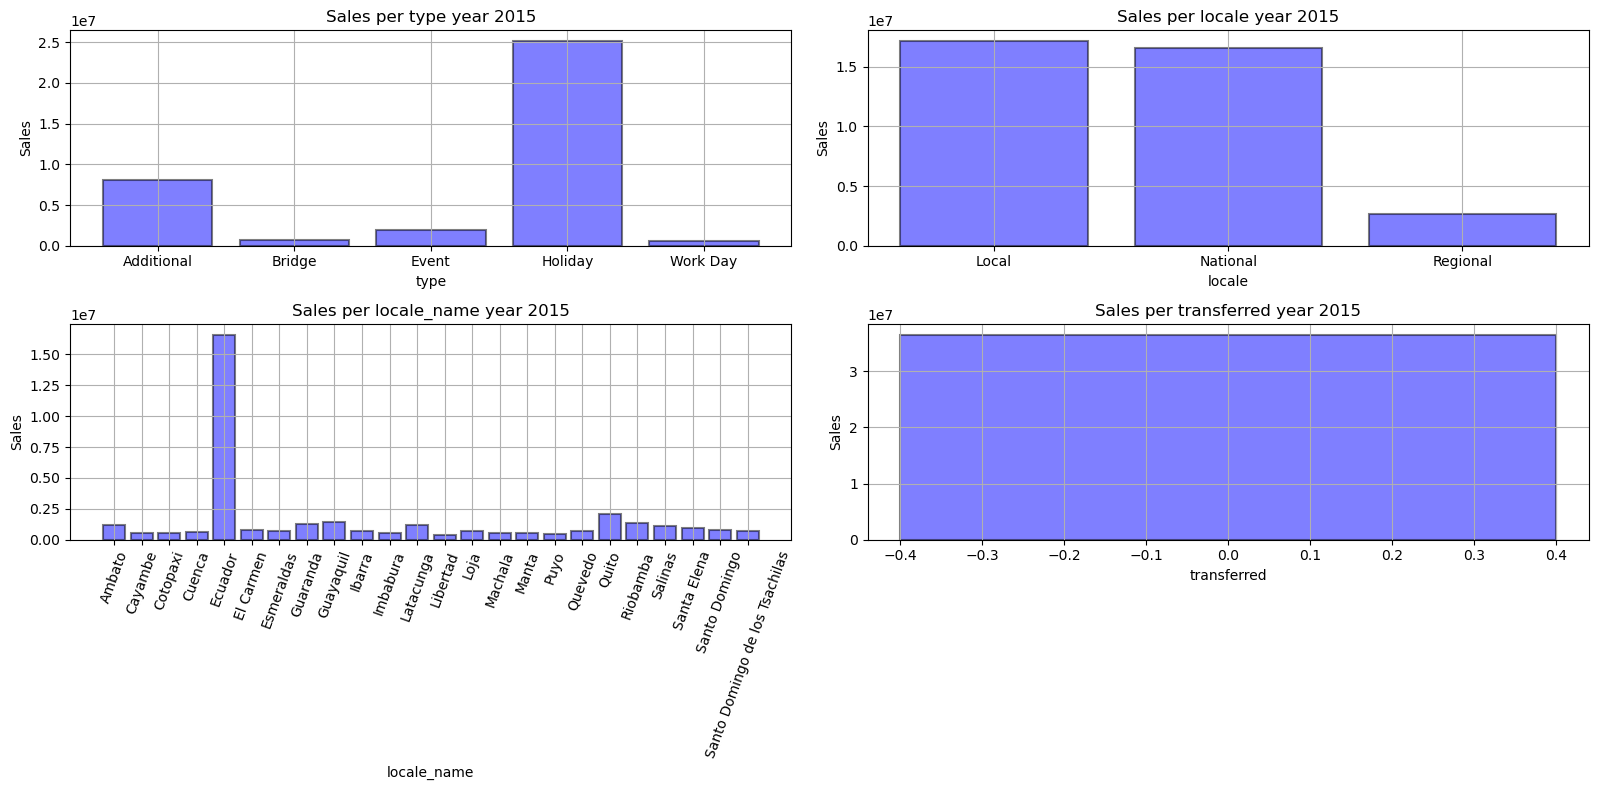







Year 2016:


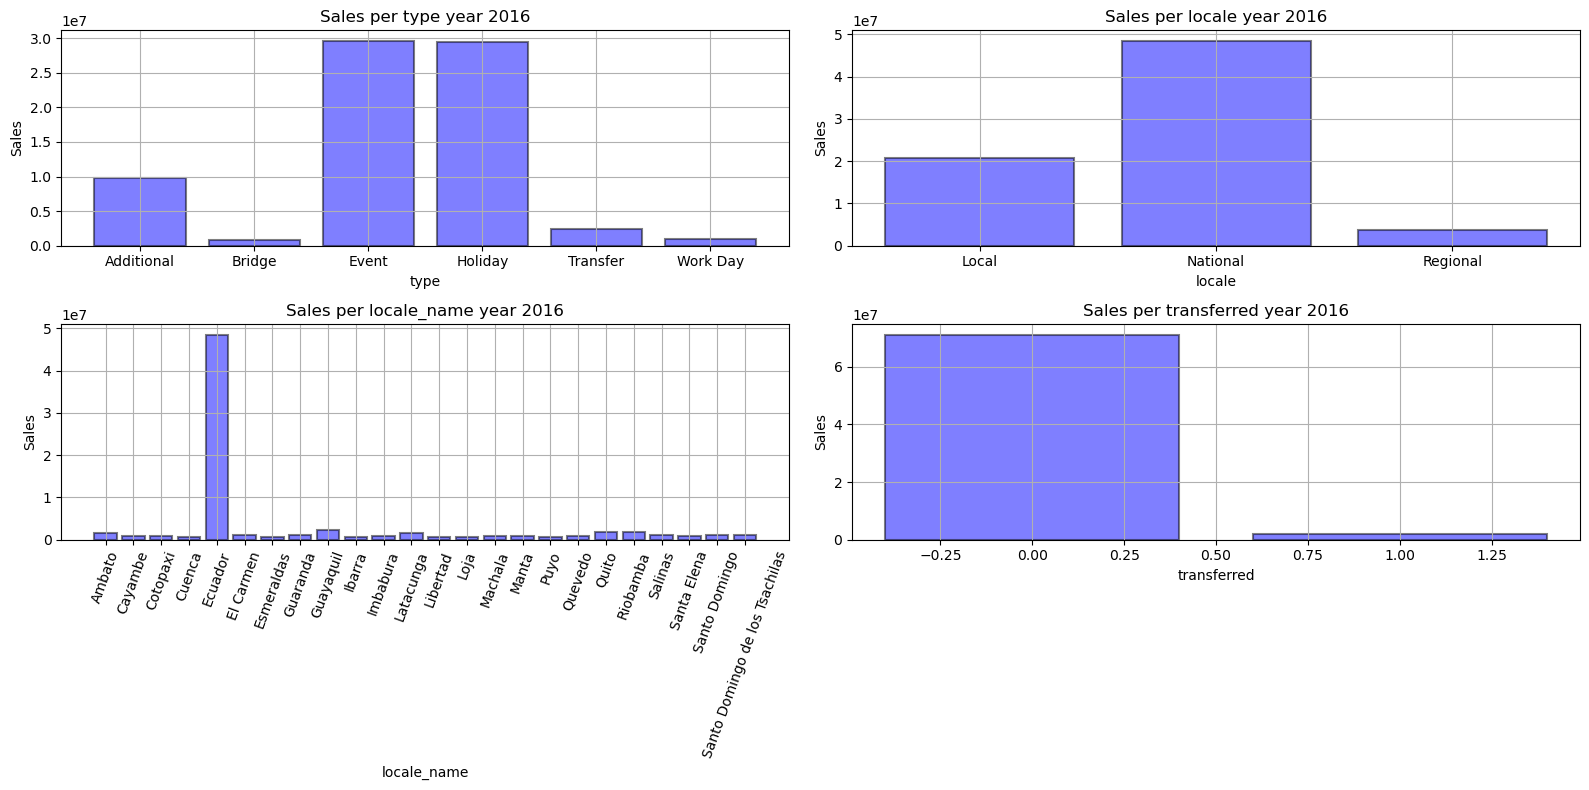







Year 2017:


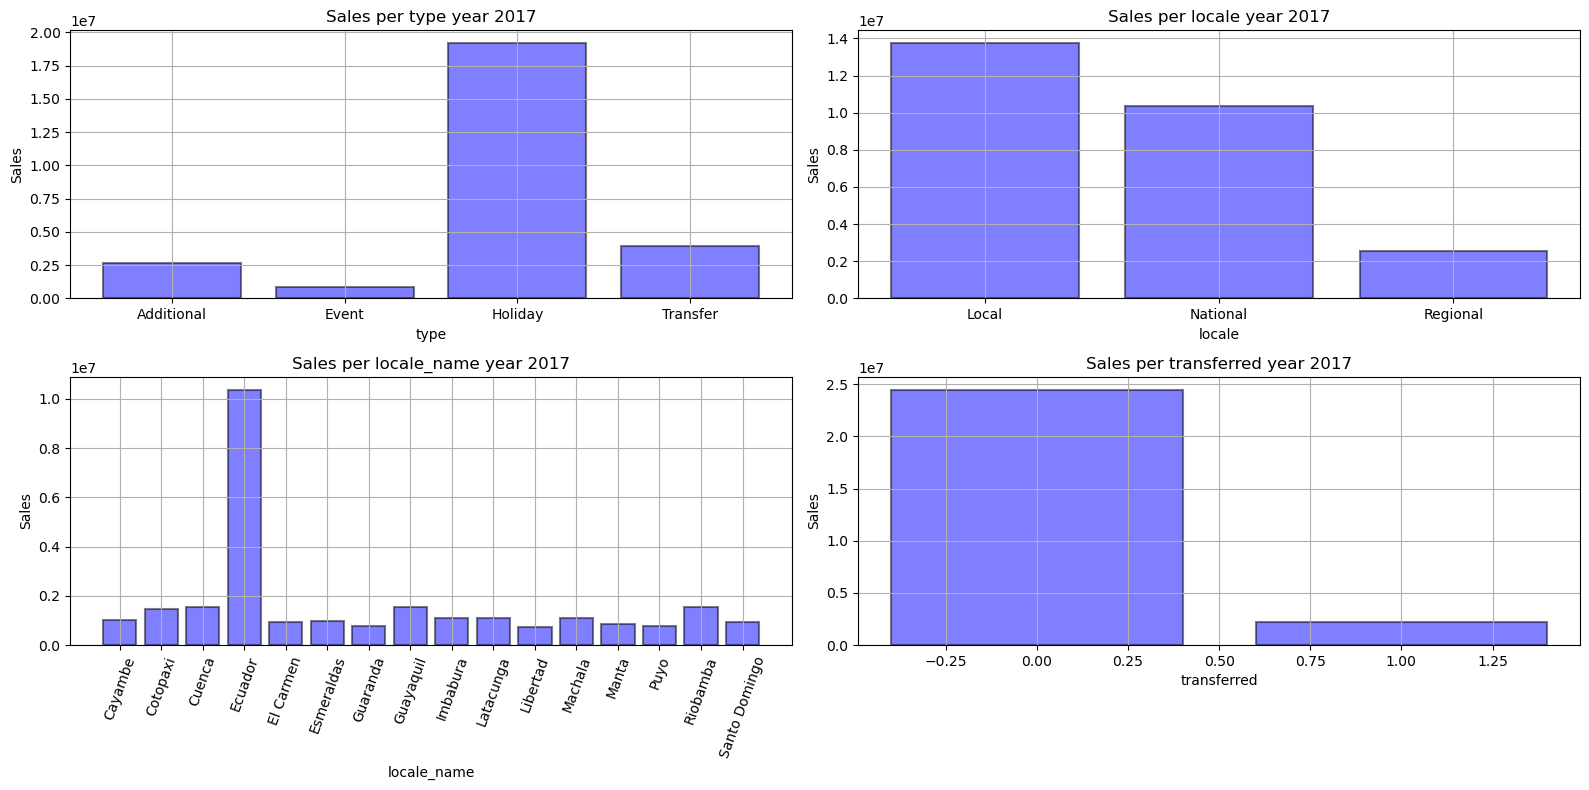

In [216]:
import matplotlib.pyplot as plt
import pandas as pd

list_name=["type", "locale", "locale_name", "transferred"]
list_year=list(holiday_sales_df.Year_y.unique())
colors=["blue", "red", "green", "yellow", "purple"]

for year in list_year:
    print("Year {}:".format(year))
    holiday_sales_year_df = holiday_sales_df[holiday_sales_df.Year_y == year]

    nrows=2
    ncols=2
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 8))

    i=0  # rows
    j=0  # columns

    for name in list_name:
        hist_holiday_sales_year_df = holiday_sales_year_df.groupby([name], as_index=False).agg({"sales": "sum"})
        axs[i,j].bar(hist_holiday_sales_year_df[name], hist_holiday_sales_year_df["sales"], color="blue", alpha=0.5, edgecolor="black", linewidth=1.5)
        axs[i,j].set_title("Sales per {} year {}".format(name, year))
        axs[i,j].set_ylabel("Sales")
        axs[i,j].set_xlabel(name)
        if name=="locale_name":
            axs[i,j].tick_params(axis="x", rotation=70)
        else:
            axs[i,j].tick_params(axis="x", rotation=0)
        axs[i, j].grid(True)
        j += 1
        if j == ncols:
            i += 1
            j = 0

    plt.tight_layout()
    plt.show()
    print("\n")
    print("\n")
    print("\n")

In [ ]:
"""

print(train_df.store_nbr.unique(), 
      train_df.family.unique(),
     len(train_df.sales.unique()),
     train_df.onpromotion.unique())
"""

In [ ]:
print("Size of the pandas is: ", test_df.shape)
print(" ")
print("The number of null elements (NaN) is: \n", test_df.isnull().sum())
print(" ")
print("Information is: \n", test_df.describe())
print(" ")
test_df.head()
#We have to predict sales. We will use a RNN (LSTM)

In [ ]:
print("Size of the pandas is: ", transactions_df.shape)
print(" ")
print("The number of null elements (NaN) is: \n", transactions_df.isnull().sum())
print(" ")
print("Information is: \n", transactions_df.describe())
print(" ")
transactions_df.head()